<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">

# Nipype on Neurodesk
#### An interactive RISE slideshow


<p style="font-size: 15px;"> <b>Author:</b> Monika Doerig </p>


<p style="font-size: 12px;">Press <code>Space</code> to proceed through the slideshow.</p>

### Output CPU information

In code cells you press `Shift-Enter` (as usual) to evaluate your code and directly move to the next cell if it is already displayed. 

Press `Ctrl-Enter` to run a command without direclty moving to the next cell.



In [1]:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


<p style="font-size: 18px;">Keep pressing <code>Space</code> to advance to the next slide.</p>

<div class="hint">
  <p class="hint-title" style="font-size: 1.5em; color: green;"><i class="fas fa-bullseye" style="color: green;"></i> <span style="font-size: 1.5em;">Objectives</span></p>
  <ul>
    <li>Know the basics of Nipype</li>
    <li>And how to use it on Neurodesk</li>
    <li>Learn how Python can be applied to analyze neuroimaging data through practical examples</li>
    <li>Get pointers to resources</li>
  </ul>
</div>

<div class="important">
  <p class="important-title" style="font-size: 1.5em; color: blue;"><i class="fas fa-bolt" style="color: blue;"></i> <span style="font-size: 1.5em;">Be aware ...</span></p>
  <ul>
    <li>Nipype is part of a large ecosystem</li>
    <li>Therefore, it is about knowing what is out there and empowering you with new tools</li>
    <li>Sometimes, the devil is in the details</li>
    <li>Things take time</li>
  </ul>
</div>

  ## Table of content
  [1. Introduction to Nipype](#1.-Introduction-to-Nipype)  
  [2. Nipype in Jupyter Notebooks on Neurodesk](#2.-Nipype-in-Jupyter-Notebooks-on-Neurodesk)  
  [3. Exploration of Nipype's building blocks](#3.-Exploration-of-Nipype's-building-blocks)  
  [4. Pydra: A modern dataflow engine developed for the Nipype project](#4.-Pydra:-A-modern-dataflow-engine-developed-for-the-Nipype-project)

## 1. Introduction to Nipype

<center><img src="https://miykael.github.io/nipype_tutorial/static/images/logoNipype_text.png" width="50%" height="50%"></center>

- Open-source Python project that originated within the neuroimaging community
- Provides a unified interface to diverse neuroimaging packages including ANTS, SPM, FSL, FreeSurfer, and others
- Facilitates seamless interaction between these packages
- Its flexibility has made it a preferred basis for widely used pre-processing tools such as fMRIPrep

$\rightarrow$ A primary goal driving Nipype is to simplify the integration of various analysis packages, allowing for the utilization of algorithms that are most appropriate for specific problems.

<img src="https://miykael.github.io/nipype_tutorial/static/images/nipype_example_graph.png" style="display: block; margin: auto auto; padding: 5px;" width="50%" height="50%"> 
<figcaption style="text-align: center;"><b>Figure 1:</b> Example Workflow</figcaption>

## 2. Nipype in Jupyter Notebooks on Neurodesk

<img src="https://www.neurodesk.org/static/logos/neurodesk.org_horizontal.png" style="float: right; margin: 0 auto; padding: 5px;" width="25%" height="25%">


Neurodesk project enables the use of all neuroimaging applications inside computational notebooks


__Demonstration of the module system in Python and Nipype:__


We will use the software tool ```lmod``` to manage and load different software packages and libraires. It simplifies the process of accessing and utilizing various software applications and allows users to easily switch between different versions of software packages, manage dependencies, and ensure compatibility with their computing environment.

In [2]:
# In code cells you press Shift-Enter to evaluate your code and directly move to the next cell if it is already displayed. 
# Or press Ctrl-Enter to run a command without direclty moving to the next cell.

# Use module to load any software tool with a specific version
import module
await module.load('fsl/6.0.7.4')
await module.list()

['mrtrix3/3.0.4', 'fsl/6.0.7.4']

In [3]:
import os
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ" # Default is NIFTI

In [4]:
from nipype.interfaces.fsl.base import Info
print(Info.version())
print(Info.output_type())
# If the FSL version is changed using lmod above, the kernel of the notebook needs to be restarted!

6.0.7.4
NIFTI_GZ


In [5]:
# Load afni and spm as well
await module.load('afni/22.3.06')
await module.load('spm12/r7771') 
await module.list()

['mrtrix3/3.0.4', 'fsl/6.0.7.4', 'afni/22.3.06', 'spm12/r7771']

## 3. Exploration of Nipype's building blocks
<center><img src="https://miykael.github.io/nipype_tutorial/static/images/nipype_architecture.png" width="50%" height="50%"></center>
  <figcaption><b>Figure 2:</b> Nipype architecture</figcaption>

- <font size="5">__Interfaces:__ Wraps a program/ function </font>

- <font size="5">__Workflow engine:__</font>
    - <font size="3">__Nodes:__ Wraps an interface for use in a workflow</font>
    - <font size="3">__Workflows:__ A directed graph or forest of graphs whose edges represent data flow </font>

- <font size="5">__Data Input:__ Many different modules to grab/ select data depending on the data structure </font>

- <font size="5">__Data Output:__ Different modules to handle data stream output  </font>

- <font size="5">__Plugin:__ A component that describes how a Workflow should be executed</font>

##### __Preparation: Download of opensource data, installations and imports__

In [6]:
# Download 2 subjects of the Flanker Dataset
PATTERN = "sub-0[1-2]"
 
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ds000102 && datalad get $PATTERN

action summary:
  get (notneeded: 2)


In [7]:
%%capture
! pip install nilearn nibabel numpy

In [8]:
from nipype import Node, Workflow, DataGrabber, DataSink
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces import fsl
from nilearn import plotting 
from IPython.display import Image
import os
from os.path import join as opj
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib 

# Create directory for all the outputs (if it doesn't exist yet)
! [ ! -d output ] && mkdir output

#### 3.1. Interfaces : The core pieces of Nipype

Python wrapper around a particular piece of software (even if it is written in another programming language than python):

    - FSL
    - AFNI
    - ANTS
    - FreeSurfer
    - SPM
    - dcm2nii
    - Nipy
    - MNE
    - DIPY
    - ...

Such an interface knows what sort of options an external program has and how to execute it (e.g., keeps track of the inputs and outputs, and checks their expected types).

In the Nipype framework we can get an information page on an interface class by using the ```help()``` function.


##### __Example: Interface for FSL's Brain Extraction Tool *BET*__

In [9]:
# help() function to get a general explanation of the class as well as a list of possible (mandatory and optional) input and output parameters 
fsl.BET.help()

Wraps the executable command ``bet``.

FSL BET wrapper for skull stripping

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                input file to skull strip
                argument: ``%s``, position: 0

        [Optional]
        out_file: (a pathlike object or string representing a file)
                name of output skull stripped image
                argument: ``%s``, position: 1
        outline: (a boolean)
                create surface outline image
                argument: ``-o``
        mask: (a boolean)
                c

In [10]:
# Create an instance of the fsl.BET object
skullstrip = fsl.BET()

# Set input (and output)
skullstrip.inputs.in_file = './ds000102/sub-01/anat/sub-01_T1w.nii.gz' 

skullstrip.inputs.out_file = './output/T1w_nipype_bet.nii.gz' # Interfaces by default spit out results to the local directory why relative paths work (outputs are not stored in temporary files like in Nodes/Workflow)

In [11]:
# Execute the node and shows outputs 
res = skullstrip.run()
res.outputs


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = <undefined>
meshfile = <undefined>
out_file = /home/jovyan/Git_repositories/example-notebooks/books/workflows/output/T1w_nipype_bet.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>

In [12]:
# Gives you transparency to what's happening under the hood with one additional line
skullstrip.cmdline

'bet ds000102/sub-01/anat/sub-01_T1w.nii.gz output/T1w_nipype_bet.nii.gz'

#### 3.2. Nodes: The light wrapper around interfaces

- To streamline the analysis and to execute multiple interfaces in a sensible order, they need to be put in a Node.
- A node is an object that executes a certain function: Nipype interface, a user-specified function or an external script. 


Each node consists of a name, an interface category and at least one input field, and at least one output field.

$\rightarrow$ Nodes expose inputs and outputs of the Interface as its own and add additional functionality allowing to connect Nodes into a Workflow (directed graph):

<img src="https://miykael.github.io/nipype_tutorial/static/images/node_two_nodes.png" style="display: block; margin: 0 auto; padding: 30px;" width="50%" height="50%">
<figcaption><b>Figure 3:</b> Nipype Nodes</figcaption>

#### MapNode
- Quite similar to a normal Node, but it can take a list of inputs and operate over each input separately, ultimately returning a list of outputs.
- Example:  Multiple functional images (A) and each of them should be motion corrected (B1, B2, B3,..). Afterwards, put them all together into a GLM, i.e. the input for the GLM should be an array of [B1, B2, B3, ...].

<center><img src=https://miykael.github.io/nipype_tutorial/static/images/mapnode.png></center>
<figcaption><b>Figure 4:</b> MapNode</figcaption>


#### Iterables
- For repetitive steps: Iterables split up the execution workflow into many different branches.
- Example: Running the same preprocessing on multiple subjects or doing statistical inference on multiple files.

<center><img src=https://miykael.github.io/nipype_tutorial/static/images/iterables.png></center>
<figcaption><b>Figure 5:</b> Iterables</figcaption>

#### JoinNode
- Has the opposite effect of iterables: JoinNode merges the different branches back into one node.
- A JoinNode generalizes MapNode to operate in conjunction with an upstream iterable node to reassemble downstream results, e.g., to merge files into a group level analysis.

<center><img src=https://miykael.github.io/nipype_tutorial/static/images/joinnode.png></center>
<figcaption><b>Figure 6:</b> JoinNode</figcaption>


##### __Example: Node__

```javascript
nipype.pipeline.engine.nodes module

nodename = Nodetype(interface_function(), name='labelname')
```

- __nodename:__ Variable name of the node in the python environment.
- __Nodetype:__ Type of node: Node, MapNode or JoinNode.
- __interface_function:__ Function the node should execute. Can be user specific or coming from an Interface.
- __labelname:__ Label name of the node in the workflow environment (defines the name of the working directory).

    - To execute a node, apply the ```.run()``` method
    - To return the output fields of the underlying interface, use ```.outputs```
    - To get help, ```.help()``` prints the interface help
 


The specification of base_dir is very important (and is why we needed to use absolute paths above) because otherwise all the outputs would be saved somewhere in the temporary files. Unlike interfaces, which by default spit out results to the local directly, the Workflow engine executes things off in its own directory hierarchy.

In [13]:
# Create FSL BET Node with fractional intensity threshold of 0.3 and create a binary mask image

# For reasons that will become clear in the Workflow section, it's important to pass filenames to Nodes as absolute paths.
input_file = opj(os.getcwd(), 'ds000102/sub-01/anat/sub-01_T1w.nii.gz') 
output_file = opj(os.getcwd(), 'output/T1w_nipype_bet.nii.gz')

# Create FSL BET Node with fractional intensity threshold of 0.3 and create a binary mask image
bet = Node(fsl.BET(), name='bet_node')

# Define inputs 
bet.inputs.frac = 0.3
bet.inputs.mask = True
bet.inputs.in_file = input_file
bet.inputs.out_file = output_file

# Run the node
res = bet.run()

250606-01:27:47,466 nipype.workflow INFO:
	 [Node] Setting-up "bet_node" in "/tmp/tmp13hyf_z5/bet_node".
250606-01:27:47,470 nipype.workflow INFO:
	 [Node] Executing "bet_node" <nipype.interfaces.fsl.preprocess.BET>
250606-01:27:51,451 nipype.workflow INFO:
	 [Node] Finished "bet_node", elapsed time 3.979764s.


In [14]:
# Shows produced outputs 
res.outputs


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/jovyan/Git_repositories/example-notebooks/books/workflows/output/T1w_nipype_bet_mask.nii.gz
meshfile = <undefined>
out_file = /home/jovyan/Git_repositories/example-notebooks/books/workflows/output/T1w_nipype_bet.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>

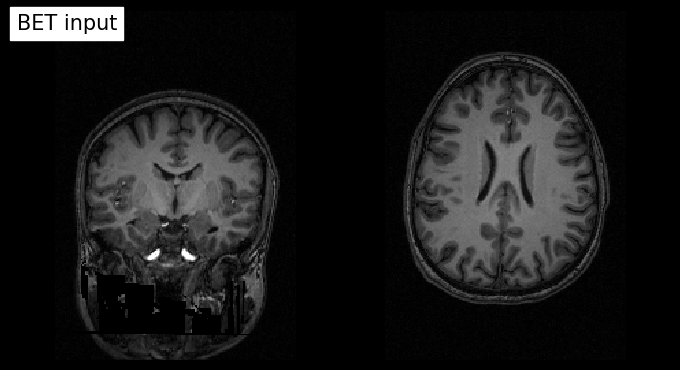

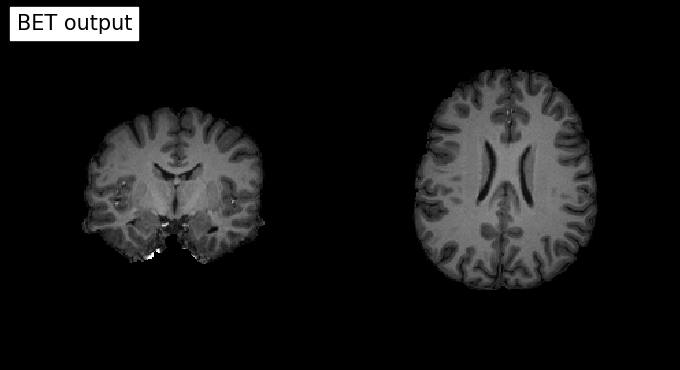

In [15]:
# Plot original input file
plotting.plot_anat(input_file, title='BET input', cut_coords=(10,10,10),
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

# Plot skullstripped output file (out_file) through the outputs property
plotting.plot_anat(res.outputs.out_file, title='BET output', cut_coords=(10,10,10),
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False);

#### 3.3. Workflows
- Define functionality for pipelined execution of interfaces
- Consist of multiple nodes, each representing a specific interface.
- The processing stream is encoded as a directed acyclic graph (DAG), where each stage of processing is a node. Nodes are unidirectionally dependent on others, ensuring no cycles and clear directionality. The Node and Workflow classes make these relationships explicit.
- Edges represent the data flow between nodes.
- Control the setup and the execution of individual interfaces.
- Will take care of inputs and outputs of each interface and arrange the execution of each interface in the most efficient way.

```javascript
nipype.pipeline.engine.workflows module

Workflow(name, base_dir=None)
```
- __name:__ Label name of the workflow.
- __base_dir:__ Defines the working directory for this instance of workflow element. Unlike interfaces, which by default store results in the local directory, the Workflow engine executes things off in its own directory hierarchy. By default (if not set manually), it is a temporary directory (/tmp).

Workflow methods that we will use during this tutorial:
- ```Workflow.connect()```: Connect nodes in the pipeline 
- ```Workflow.write_graph()```: Generates a graphviz dot file and a png file
- ```Workflow.run()```: Execute the workflow

##### __Example: Workflow__

First, define different nodes to: 
- Skullstrip an image to obtain a mask
- Smooth the original image
- Mask the smoothed image

In [16]:
in_file = input_file # See node example

# Skullstrip process
skullstrip = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")

# Smooth process
smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm=4), name="smooth")

# Mask process
mask = Node(fsl.ApplyMask(), name="mask")

In [17]:
# Create a working directory for all workflows created during this workshop
! [ ! -d output/working_dir ] && mkdir output/working_dir

wf_work_dir = opj(os.getcwd(), 'output/working_dir') 

# Initiation of a workflow with specifying the working directory.
# This specification of base_dir is very important (and is why we needed to use absolute paths above for the input files) because otherwise all the outputs would be saved somewhere in the temporary files.
wf = Workflow(name="smoothflow", base_dir=wf_work_dir )

##### Connect nodes within a workflow
- method called ```connect``` that is going to do most of the work
- checks if inputs and outputs are actually provided by the nodes that are being connected

$\rightarrow$ There are two different ways to call connect:

Establish one connection at a time:
```javascript
wf.connect(source, "source_output", dest, "dest_input") 
```

Establish multiple connections between two nodes at once:
```javascript
wf.connect([(source, dest, [("source_output1", "dest_input1"),
                         ("source_output2", "dest_input2")
                         ])
         ]) 
```

In [18]:
# Option 1: connect the binary mask of the skullstripping process to the mask node
wf.connect(skullstrip, "mask_file", mask, "mask_file")

# Option 2: connect the output of the smoothing node to the input of the masking node
wf.connect([(smooth, mask, [("out_file", "in_file")])])

250606-01:27:55,578 nipype.workflow INFO:
	 Generated workflow graph: /home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/smoothflow/workflow_graph.png (graph2use=hierarchical, simple_form=True).


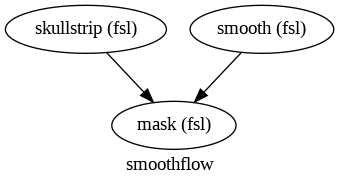

In [19]:
# Explore the workflow visually
wf.write_graph(dotfilename="workflow_graph.dot")

Image(filename=opj(wf_work_dir,"smoothflow/workflow_graph.png"))

250606-01:27:55,939 nipype.workflow INFO:
	 Generated workflow graph: /home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/smoothflow/graph.png (graph2use=flat, simple_form=True).


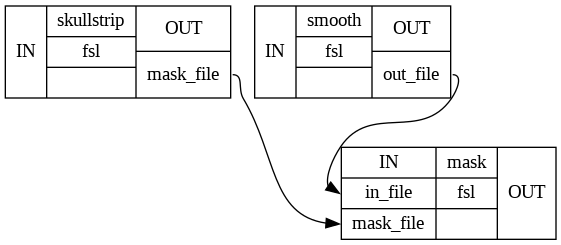

In [20]:
# Certain graph types also allow you to further inspect the individual connections between the nodes
wf.write_graph(graph2use='flat')

Image(filename=opj(wf_work_dir,"smoothflow/graph_detailed.png"))  

In [21]:
# Execute the workflow (running serially here)
wf.run()

250606-01:27:55,951 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
250606-01:27:55,955 nipype.workflow INFO:
	 Running serially.
250606-01:27:55,956 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/smoothflow/skullstrip".
250606-01:27:55,959 nipype.workflow INFO:
	 [Node] Executing "skullstrip" <nipype.interfaces.fsl.preprocess.BET>
250606-01:27:59,939 nipype.workflow INFO:
	 [Node] Finished "skullstrip", elapsed time 3.9788740000000002s.
250606-01:27:59,943 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/smoothflow/smooth".
250606-01:27:59,945 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.fsl.maths.IsotropicSmooth>
250606-01:28:07,569 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 7.62334500

In [22]:
# Check the working directories of the workflow
!tree  output/working_dir/smoothflow/ -I '*js|*json|*html|*pklz|_report'

output/working_dir/smoothflow/
├── graph.dot
├── graph.png
├── graph_detailed.dot
├── graph_detailed.png
├── mask
│   ├── command.txt
│   └── sub-01_T1w_smooth_masked.nii.gz
├── skullstrip
│   ├── command.txt
│   └── sub-01_T1w_brain_mask.nii.gz
├── smooth
│   ├── command.txt
│   └── sub-01_T1w_smooth.nii.gz
├── workflow_graph.dot
└── workflow_graph.png

3 directories, 12 files


In [23]:
# Helper function to plot 3D NIfTI images
def plot_slice(fname):

    # Load the image
    img = nib.load(fname)
    data = img.get_fdata()

    # Cut in the middle of the brain
    cut = int(data.shape[-1]/2) + 10

    # Plot the data
    plt.imshow(np.rot90(data[..., cut]), cmap="gray")
    plt.gca().set_axis_off()

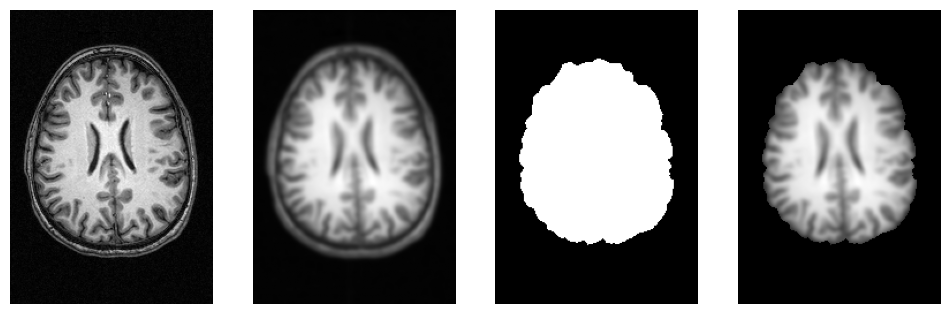

In [24]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate([input_file,
                         opj(wf_work_dir, "smoothflow/smooth/sub-01_T1w_smooth.nii.gz"),
                         opj(wf_work_dir, "smoothflow/skullstrip/sub-01_T1w_brain_mask.nii.gz"),
                         opj(wf_work_dir, "smoothflow/mask/sub-01_T1w_smooth_masked.nii.gz")]):
    f.add_subplot(1, 4, i + 1)
    plot_slice(img)

#### 3.4. Execution Plugins: Execution on different systems

Allow seamless execution across many architectures and make using parallel computation quite easy.

- Local Machines:
    - __Serial__: Runs the workflow one node at a time in a single process locally. The order of the nodes is determined by a topolocial sort of the workflow.
    - __Multicore__: Uses the Python multiprocessing library to distribute jobs as new processes on a local system.


- Submission to Cluster Schedulers:
    - Plugins like HTCondor, PBS, SLURM, SGE, OAR, and LSF submit jobs to clusters managed by these job scheduling systems.

- Advanced Cluster Integration:
    - __DAGMan__: Manages complex workflow dependencies for submission to DAGMan cluster scheduler.
    - __IPython__: Utilizes IPython parallel computing capabilities for distributed execution in clusters.

- Specialized Execution Plugins:
    - __Soma-Workflow__: Integrates with Soma-Workflow system for distributed execution in HPC environments.


<p class="important-title" style="font-size: 1.2em; color: red;"><i class="fas fa-exclamation-circle" style="color: red;"></i> <span style="font-size: 1.5em;">Cluster operation often needs a special setup.</span></p>


All plugins can be executed with:
```javascript
workflow.run(plugin=PLUGIN_NAME, plugin_args=ARGS_DICT)
```

To run the workflow one node at a time:
```javascript
wf.run(plugin='Linear')
```

To distribute processing on a multicore machine, number of processors/threads will be automatically detected:
```javascript
wf.run(plugin='MultiProc') 
```

Plugin arguments:
```javascript
arguments = {'n_procs' : num_threads,
               'memory_gb' : num_gb} 

wf.run(plugin='MultiProc', plugin_args=arguments)
```

In order to use Nipype with SLURM simply call:

```javascript
wf.run(plugin='SLURM')
``` 

<p style="font-size: 13px;">Optional arguments:</p>

<p style="font-size: 13px;"><code>template</code>: If you want to use your own job submission template (the plugin generates a basic one by default).</p>

<p style="font-size: 13px;"><code>sbatch_args</code>: Takes any arguments such as nodes/partitions/gres/etc that you would want to pass on to the sbatch command underneath.</p>

<p style="font-size: 13px;"><code>jobid_re</code>: Regular expression for custom job submission id search.</p>

#### 3.5. Data Input: First step of every analysis
Nipype provides many different modules how to get the data into the framework. 

We will work through an example with the DataGrabber module:

- __DataGrabber:__  Versatile input module to retrieve data from a local file system based on user-defined search criteria, including wildcard patterns, regular expressions, and directory hierarchies. It supports almost any file organization of your data.



But there are many more alternatives available:
- __SelectFiles:__ A simpler alternative to the DataGrabber interface, built on Python format strings. Format strings allow you to replace named sections of template strings set off by curly braces ({}).
- __BIDSDataGrabber:__ Get neuroimaging data organized in BIDS-compliant directory structures. It simplifies the process of accessing and organizing neuroimaging data for analysis pipelines.
- __DataFinder:__  Search for paths that match a given regular expression. Allows a less proscriptive approach to gathering input files compared to DataGrabber.
- __FreeSurferSource:__ Specific case of a file grabber that facilitates the data import of outputs from the FreeSurfer recon-all algorithm.
- __JSONFileGrabber:__ Datagrabber interface that loads a json file and generates an output for every first-level object.
- __S3DataGrabber:__ Pull data from an Amazon S3 Bucket. 
- __SSHDataGrabber:__ Extension of DataGrabber module that downloads the file list and optionally the files from a SSH server. 
- __XNATSource:__ Pull data from an XNAT server.

##### __Example: DataGrabber__
Let's assume we want to grab the anatomical and functional images of certain subjects of the Flanker dataset:

In [25]:
!tree -L 4 ds000102/ -I '*csv|*pdf'

ds000102/
├── CHANGES
├── README
├── T1w.json
├── dataset_description.json
├── derivatives
│   └── mriqc
├── participants.tsv
├── sub-01
│   ├── anat
│   │   └── sub-01_T1w.nii.gz -> ../../.git/annex/objects/Pf/6k/MD5E-s10581116--757e697a01eeea5c97a7d6fbc7153373.nii.gz/MD5E-s10581116--757e697a01eeea5c97a7d6fbc7153373.nii.gz
│   └── func
│       ├── sub-01_task-flanker_run-1_bold.nii.gz -> ../../.git/annex/objects/5m/w9/MD5E-s28061534--8e8c44ff53f9b5d46f2caae5916fa4ef.nii.gz/MD5E-s28061534--8e8c44ff53f9b5d46f2caae5916fa4ef.nii.gz
│       ├── sub-01_task-flanker_run-1_events.tsv
│       ├── sub-01_task-flanker_run-2_bold.nii.gz -> ../../.git/annex/objects/2F/58/MD5E-s28143286--f0bcf782c3688e2cf7149b4665949484.nii.gz/MD5E-s28143286--f0bcf782c3688e2cf7149b4665949484.nii.gz
│       └── sub-01_task-flanker_run-2_events.tsv
├── sub-02
│   ├── anat
│   │   └── sub-02_T1w.nii.gz -> ../../.git/annex/objects/3m/FF/MD5E-s10737123--cbd4181ee26559e8ec0a441fa2f834a7.nii.gz/MD5E-s10737123--cbd4181ee26

The two files we desire are at the following locations:


- __anatomical image:__  <span style="color:blue">ds000102</span>/<span style="color:orange">sub-01</span>/anat/<span style="color:orange">sub-01</span>_T1w.nii.gz

- __functional image:__ <span style="color:blue">ds000102</span>/<span style="color:orange">sub-01</span>/func/<span style="color:orange">sub-01</span>_task-flanker<span style="color:red">_run-1</span>_bold.nii.gz

This means that we can rewrite the paths as follows:

- __anat__ = <span style="color:blue">base_directory</span>/sub-<span style="color:orange">[subject_id]</span>/anat/sub-<span style="color:orange">[subject_id]</span>_T1w.nii.gz

- __func__ = <span style="color:blue">base_directory</span>/sub-<span style="color:orange">[subject_id]</span>/func/sub-<span style="color:orange">[subject_id]</span>\_task-flanker_run_<span style="color:red">[run_id]</span>_bold.nii.gz



Therefore, we need the parameters <span style="color:orange">subject_id</span> for the anatomical image and the parameters <span style="color:orange">subject_id</span>, and <span style="color:red">run_id</span> for the functional images. In the context of DataGabber, this is specified as follows:

In [26]:
# Input: Set the input file path
data_dir = opj(os.getcwd(), 'ds000102') #base_directory of the data

# Dynamic parameters
subj_list = ['01', '02'] #subject_id
run_list = [1, 2] #run_id

# Initialise workflow
wf_input = Workflow(name='data_input', base_dir=wf_work_dir) # base_dir: Set path where nipype will store stepwise results
wf_input.config["execution"]["crashfile_format"] = "txt"

In [27]:
# Create DataGrabber node with input fields for all dynamic parameters (e.g. subject identifier, run identifier), 
# as well as the two desired output fields anat and func.

dg = Node(
    interface= DataGrabber(infields=["subject_id","run_id"], outfields=["anat", "func"]),
    name="dg")

# Location of dataset folder
dg.inputs.base_directory = data_dir
# Necessary default parameters
dg.inputs.sort_filelist = True #return a sorted filelist to ensure to match files to correct runs/tasks
dg.inputs.template = "*" #wildcard
# Specify run_ids
dg.inputs.run_id = run_list

In [28]:
# Define arguments to fill the wildcards in the below paths 
dg.inputs.template_args = dict(
    anat=[["subject_id","subject_id"]],
    func=[["subject_id","subject_id","run_id"]],
)

# Specify the template structure to find the specific data
dg.inputs.field_template = dict(
    anat="sub-%s/anat/sub-%s_T1w.nii.gz",
    func="sub-%s/func/sub-%s_task-flanker_run-%d_bold.nii.gz",
)

To feed dynamic parameters into the node either do this by specifying them directly as node inputs, or using another node and feed **subject_id** as connections to the DataGrabber node.

Specifying the input fields of DataGrabber directly for one subject:
```javascript
dg.inputs.subject_id = '01'
```

If we want to start our workflow from creating subgraphs, i.e. running it for more than one subject, we can use another node:
__IdentityInterface__, which is a special use case of **iterables**. It allows to create Nodes that do simple identity mapping, i.e. Nodes that only work on parameters/strings.

In [29]:
infosource = Node(IdentityInterface(fields=["subject_id"]),
                  name="infosource")
# Run a workflow iterating over various inputs using the iterables attribute of nodes --> splits up the workflow
infosource.iterables = [("subject_id", subj_list)]

In [30]:
# Connect the nodes and run the workflow
wf_input.connect([(infosource, dg, [("subject_id", "subject_id")])])

wf_input.run()

250606-01:28:12,517 nipype.workflow INFO:
	 Workflow data_input settings: ['check', 'execution', 'logging', 'monitoring']
250606-01:28:12,524 nipype.workflow INFO:
	 Running serially.
250606-01:28:12,525 nipype.workflow INFO:
	 [Node] Setting-up "data_input.dg" in "/home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/data_input/_subject_id_01/dg".
250606-01:28:12,536 nipype.workflow INFO:
	 [Node] Executing "dg" <nipype.interfaces.io.DataGrabber>
250606-01:28:12,539 nipype.workflow INFO:
	 [Node] Finished "dg", elapsed time 0.000577s.
250606-01:28:12,541 nipype.workflow INFO:
	 [Node] Setting-up "data_input.dg" in "/home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/data_input/_subject_id_02/dg".
250606-01:28:12,544 nipype.workflow INFO:
	 [Node] Executing "dg" <nipype.interfaces.io.DataGrabber>
250606-01:28:12,546 nipype.workflow INFO:
	 [Node] Finished "dg", elapsed time 0.000316s.


#### 3.6. Data Output

A workflow working directory is like a cache containing the outputs of various processing stages and various extraneous information such as execution reports, hashfiles determining the input state of processes.

In [31]:
!tree  output/working_dir/smoothflow/ -I '*js|*dot|*png|*html|*json'

output/working_dir/smoothflow/
├── mask
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── command.txt
│   ├── result_mask.pklz
│   └── sub-01_T1w_smooth_masked.nii.gz
├── skullstrip
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── command.txt
│   ├── result_skullstrip.pklz
│   └── sub-01_T1w_brain_mask.nii.gz
└── smooth
    ├── _inputs.pklz
    ├── _node.pklz
    ├── _report
    │   └── report.rst
    ├── command.txt
    ├── result_smooth.pklz
    └── sub-01_T1w_smooth.nii.gz

6 directories, 18 files


Data output modules allow to *restructure* and *rename* computed output and to spatially differentiate relevant output files from the temporary computed intermediate files in the working directory. 

In this tutorial, we will look into the DataSink module:
- __DataSink:__ Nipype's standard output module, which allows the creation of arbitrary input attributes. The names of these attributes define the directory structure to be created for storing the files or directories.

Nipype also provides some simple frontends for storing values into a JSON File, MySQL and SQLite database or an XNAT Servers.
- __JSONFileSink__ 
- __MySQLSink__ 
- __SQLiteSink__ 
- __XNATSink__ 

##### __Example: DataSink__

The following code segment defines the DataSink node and sets the ```base_directory``` in which all outputs will be stored. The ```container``` input creates a subdirectory within the base_directory.

```javascript
from nipype.interfaces.io import DataSink


datasink = Node(DataSink(), name='sinker')
datasink.inputs.base_directory = '/path/to/output'
workflow.connect(inputnode, 'subject_id', datasink, 'container')
```

To store different outputs in the same place, a second port needs to be created with (.)  This stores the files in a separate subfolder called mask:
```javascript
workflow.connect(inputnode, 'mask_out_file', datasink, 'container.mask')
```

If you want to store the files in the same folder, use the .@ syntax. The @ tells the DataSink interface to not create the subfolder. This will allow to create different named input ports for DataSink and allow the user to store the files in the same folder.
```javascript
workflow.connect(inputnode, 'subject_id', datasink, 'container')
workflow.connect(inputnode, 'mask_out_file', datasink, 'container.@mask')
```

<p class="important-title" style="font-size: 1.5em; color: purple;">
    🥳 <span style="font-size: 1.5em;">Final Example: Mini-Preprocessing-Workflow</span>
</p>


- __Input Stream__: DataGrabber to grab the functional image (run-1) of sub-01
- __FSL-Interfaces__: Motion correction and spatial smoothing (kernel of 4 mm) of the functional image
- __Output Stream__: DataSink to grab the motion-corrected image, the motion parameters and the smoothed image

In [32]:
# Initialise Workflow
wf_preproc = Workflow(name='preproc', base_dir=wf_work_dir)
wf_preproc.config["execution"]["crashfile_format"] = "txt"

# DataGrabber Node
dg = Node(
    interface= DataGrabber(infields=["subject_id", "run_id"], outfields=["func"]),
    name="dg")

# Location of dataset folder
dg.inputs.base_directory = data_dir
# Necessary default parameters
dg.inputs.sort_filelist = True #return a sorted filelist to ensure to match files to correct runs/tasks
dg.inputs.template = "*"
dg.inputs.run_id = 1
dg.inputs.subject_id = '01'
dg.inputs.template_args = dict(
    func=[["subject_id", "subject_id", "run_id"]],
)

# Specify the template structure to find the specific data
dg.inputs.field_template = dict(
    func="sub-%s/func/sub-%s_task-flanker_run-%d_bold.nii.gz",
)

In [33]:
# Create Motion Correction Node
mcflirt = Node(fsl.MCFLIRT(save_plots=True), 
               name='mcflirt')

# Create Smoothing node
smooth = Node(fsl.IsotropicSmooth(fwhm=4),
              name='smooth')

# Connect the three nodes to each other
wf_preproc.connect([(dg, mcflirt, [("func", "in_file")]),
                    (mcflirt, smooth, [("out_file", "in_file")])])

In [34]:
# Create DataSink object
sinker = Node(DataSink(), name='sinker')

# Name of the output folder
sinker.inputs.base_directory = opj(wf_work_dir, 'preproc/results')

250606-01:28:13,923 nipype.workflow INFO:
	 Generated workflow graph: /home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/preproc/graph.png (graph2use=colored, simple_form=True).


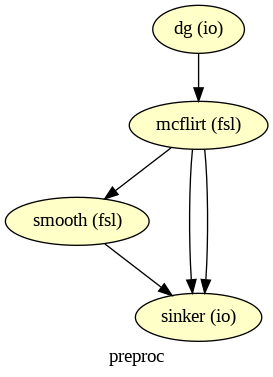

In [35]:
# Save output in one folder called 'preproc' with .@
wf_preproc.connect([(smooth, sinker, [('out_file', 'sub-01.@in_file')]),
                    (mcflirt, sinker, [('out_file', 'sub-01.@mc_img'),
                               ('par_file', 'sub-01.@par_file')]),
                   ])

# Visualize the graph
wf_preproc.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename=opj(wf_preproc.base_dir, wf_preproc.name, 'graph.png'))

In [36]:
# Run workflow with distributed processing
wf_preproc.run('MultiProc')

250606-01:28:13,932 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
250606-01:28:13,943 nipype.workflow INFO:
	 Running in parallel.
250606-01:28:13,958 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
250606-01:28:15,12 nipype.workflow INFO:
	 [Node] Setting-up "preproc.dg" in "/home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/preproc/dg".
250606-01:28:15,26 nipype.workflow INFO:
	 [Node] Executing "dg" <nipype.interfaces.io.DataGrabber>
250606-01:28:15,30 nipype.workflow INFO:
	 [Node] Finished "dg", elapsed time 0.000948s.
250606-01:28:15,960 nipype.workflow INFO:
	 [Job 0] Completed (preproc.dg).
250606-01:28:15,964 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 32/32.
250606-01:28:16,481 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" i

In [37]:
! tree output/working_dir/preproc/results

output/working_dir/preproc/results
└── sub-01
    ├── sub-01_task-flanker_run-1_bold_mcf.nii.gz
    ├── sub-01_task-flanker_run-1_bold_mcf.nii.gz.par
    └── sub-01_task-flanker_run-1_bold_mcf_smooth.nii.gz

1 directory, 3 files


<p class="important-title" style="font-size: 1.5em; color: gold;"><i class="fas fa-lightbulb" style="color: gold;"></i> <span style="font-size: 1.5em;">Tip</span></p>
<ul>
DataSink offers the substitution input field to rename output files.
For example, to get rid of the string 'bold' and to adapt the file ending of the motion parameter file:
</ul>

In [38]:
# Define substitution strings
substitutions = [('_bold', ''),
                 ('.nii.gz.par', '.par')]

# Feed the substitution strings to the DataSink node
sinker.inputs.substitutions = substitutions

# Run the workflow again with the substitutions in place
wf_preproc.run()

250606-01:29:12,288 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
250606-01:29:12,294 nipype.workflow INFO:
	 Running serially.
250606-01:29:12,295 nipype.workflow INFO:
	 [Node] Setting-up "preproc.dg" in "/home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/preproc/dg".
250606-01:29:12,298 nipype.workflow INFO:
	 [Node] Executing "dg" <nipype.interfaces.io.DataGrabber>
250606-01:29:12,300 nipype.workflow INFO:
	 [Node] Finished "dg", elapsed time 0.00033s.
250606-01:29:12,307 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/jovyan/Git_repositories/example-notebooks/books/workflows/output/working_dir/preproc/mcflirt".
250606-01:29:12,309 nipype.workflow INFO:
	 [Node] Cached "preproc.mcflirt" - collecting precomputed outputs
250606-01:29:12,310 nipype.workflow INFO:
	 [Node] "preproc.mcflirt" found cached.
250606-01:29:12,310 nipype.workflow INFO:
	 [Node] Setting-up "preproc.smooth

In [39]:
! tree output/working_dir/preproc/results

output/working_dir/preproc/results
└── sub-01
    ├── sub-01_task-flanker_run-1_bold_mcf.nii.gz
    ├── sub-01_task-flanker_run-1_bold_mcf.nii.gz.par
    ├── sub-01_task-flanker_run-1_bold_mcf_smooth.nii.gz
    ├── sub-01_task-flanker_run-1_mcf.nii.gz
    ├── sub-01_task-flanker_run-1_mcf.par
    └── sub-01_task-flanker_run-1_mcf_smooth.nii.gz

1 directory, 6 files


<p class="important-title" style="font-size: 1.1em; color: green;"><i class="fas fa-check-circle" style="color: green;"></i> <span style="font-size: 1.5em;">Nipype in a Nutshell</span></p>


Nipype offers easy to use building blocks for:

- establishing neuroimaging data processing services
- constructing tailored data processing pipelines

## 4. Pydra: A modern dataflow engine developed for the Nipype project


<img src="https://github.com/nipype/pydra/blob/main/docs/source/_static/logo/pydra_logo.jpg?raw=true" style="float: center; margin: 0 auto; padding: 5px;" width="30%" height="30%">


- Pydra is a rewrite of the Nipype engine and forms the core of the Nipype 2.0 ecosystem and is meant to provide **additional flexibility** allowing users to define custom processing steps, interfaces and nested workflows.

- Is a standalone project and designed to support analytics in **any scientific domain** (whereas Nipype is specifically designed for neuroimaging data analysis pipelines).

$\rightarrow$  Pydra aims to offer a lightweight Python (3.7+) dataflow engine for the construction, manipulation, and distributed execution of computational graphs. It serves as a tool for building reproducible, scalable, reusable, and fully automated scientific workflows.

The architecture in combination with several key features makes Pydra a customizable and powerful dataflow engine: 
- __Architecture with three core components:__ Tasks (basic runnable components) including Workflows, Submitter (Classes for unpacking Tasks into standalone jobs) and Workers (Classes used to execute Tasks coordinate resource managment).
- __Composable dataflows:__ Nested dataflows of arbitrary depths encouraging the creation of reusable dataflows.
- __Global cache__ support to reduce recomputation.
- Support for dataflow execution in __containerized environments__ enabling greater consistency for reproducibility.
- __Splitting & combining semantics__ for creating nested loops over input sets (MapReduce extended to graphs).

#### Key features in more detail:
- __Composable dataflows:__ A dataflow is represented as a directed acyclic graph, where each Task represents a Python function, execution of an external tool, or another dataflow. This enables the creation of simpe linear pipelines to complex nested dataflows of any depth. This approach promotes the development of reusable dataflows, enhancing modularity and scalability.

<center><img src= "https://github.com/nipype/pydra-tutorial/blob/master/figures/nested_workflow.png?raw=true" width="30%" height="30%"></center>
<figcaption><b>Figure 7:</b> Nested workflow</figcaption>


<div class="important">
  <p class="important-title" style="font-size: 1.3em; color: orange;"><i class="fas fa-search" style="color: orange;"></i> <span style="font-size: 1.3em;">Nipype-Pydra architectures</span></p>
  <ul>
    <li>Pydra dataflow components: Task (basic runnable component with named inputs and outputs) with subclass Workflow</li>
    <li>Nipype basic concepts: Node (defined inputs and outputs), Workflow</li>
  </ul>
</div>


- __Support for Python functions (FunctionTask) and external (shell) commands (ShellCommandTask):__ Pydra enables the seamless incorporation and utilization of pre-existing functions within Python libraries, as well as external command-line tools. This facilitates straightforward integration of existing code and software into Pydra workflows.

- __Support for execution of Tasks in containerized environments (ContainerTask):__ Any dataflow or Task can be executed in an associated container (via Docker or Singularity) enabling greater consistency for reproducibility.

<div class="important">
  <p class="important-title" style="font-size: 1.3em; color: orange;"><i class="fas fa-search" style="color: orange;"></i> <span style="font-size: 1.3em;">Nipype-Pydra architectures</span></p>
  <ul>
      <li>Pydra Task subclasses: FunctionTask, ShellCommandTask, ContainerTask (Docker, Singularity) </li>
    <li>Nipype advanced concepts: base interfaces or interfaces for using existing functionality in other packages: wrapping of command line tools (nipype.interfaces.base CommandLine), run arbitrary function as nipype interface (nipype.interfaces.utility Function)</li>
  </ul>
</div>

- __Splitting & combining semantics for creating nested loops over input sets:__ Versatile functionality for nested loop creation across input sets: Tasks or dataflows can iterate over input parameter sets, and their outputs can be recombined. This functionality resembles the Map-Reduce model, but Pydra extends this capability to graphs with nested dataflows.


<center><img src=https://nipype.github.io/pydra/_images/nd_spl_1.png></center>
<figcaption><b>Figure 8:</b> Flexible splitting and merging in Pydra</figcaption>



<div class="important">
  <p class="important-title" style="font-size: 1.3em; color: orange;"><i class="fas fa-search" style="color: orange;"></i> <span style="font-size: 1.3em;">Pydra-Nipype architectures</span></p>
  <ul>
    <li>Pydra: Optional State class: splitter and combiner attribute to specify how inputs should be split into parameter sets, and combined after Task execution</li>
    <li>Nipype: MapNode, Iterables/ Synchronize, JoinNode</li>
  </ul>
</div>


- Both Pydra and Nipype offer similar functionalities regarding

    - __Hashing__ to manage task execution and caching of intermediate results. Hashes are computed for task inputs and parameters and used to determine task dependencies and to avoid unnecessary recomputation.
    - __Provenance Tracking__ capabilities to captures dataflow execution activities as a provenance graph. It tracks inputs, outputs, and resources consumed by each task in a workflow, providing a detailed record of the workflow execution.

__A content-addressable global cache to reduce recomputation:__ Hash values are computed for each graph and each Task. This supports reusing of previously computed and stored dataflows and Tasks. It also allows multiple people in or across laboratories to use each others's execution outputs on the same data without having to rerun the same computation.

__Auditing and provenance tracking:__ Pydra provides a simple JSON-LD-based message passing mechanism to capture the dataflow execution activities as a provenance graph. These messages track inputs and outputs of each task in a dataflow, and the resources consumed by the task. 

  <p class="important-title" style="font-size: 1.3em; color: green;"><i class="fas fa-check-circle" style="color: green;"></i> <span style="font-size: 1.3em;">Take Home Message</span></p>
  <ul>
    <p><b>Pydra and Nipype are both open-source Python projects and offer similar functionalities for building and executing computational pipelines, including caching. However, they differ in their :</b></p>
    <li>
      <b>Design Philosophy:</b> Building pipelines for neuroimaging in vs. pipelines for any scientific domain 
    </li>
    <li>
      <b>Flexibility:</b> Very flexible splitting and merging semantics in Pydra to create complex pipelines of any depth
    </li>
    <li>
      <b>Execution Model:</b> Pydra leverages modern parallel and distributed computing frameworks such as Dask
    </li>
    <li>
      <b>Community and Ecosystem:</b> Well-established community and ecosystem vs. a growing community 
    </li>
  </ul>



## Dependencies in Jupyter/Python

- Using the package [watermark](https://github.com/rasbt/watermark) to print out computer characteristics and software versions.

In [40]:
%%capture
!pip install watermark

In [41]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-06-06T01:29:15.338246+00:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 9.1.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

nibabel   : 5.3.2
matplotlib: 3.10.3
IPython   : 9.1.0
nipype    : 1.8.6
nilearn   : 0.11.1
numpy     : 2.2.6



## References/ Resources

- Gorgolewski K, Burns CD, Madison C, Clark D, Halchenko YO, Waskom ML, Ghosh SS. (2011). Nipype: a flexible, lightweight and extensible neuroimaging data processing framework in Python. Front. Neuroinform. 5:13.

    - [Nipype Documentation](https://nipype.readthedocs.io/en/latest/)
    - [Nipype Github](https://github.com/nipy/nipype)
    - [Nipype Tutorial](https://miykael.github.io/nipype_tutorial/)

- Jarecka, Dorota & Goncalves, Mathias & Markiewicz, Christopher & Esteban, Oscar & Lo, Nicole & Kaczmarzyk, Jakub & Ghosh, Satrajit. (2020). Pydra - a flexible and lightweight dataflow engine for scientific analyses. 132-139. 10.25080/Majora-342d178e-012. 

    - [Pydra Documentation](https://pydra.readthedocs.io/en/latest/)
    - [Pydra Github](https://github.com/nipype/pydra)
    - [Pydra Tutorial](https://github.com/nipype/pydra-tutorial)
    - [Pydra-ML](https://github.com/nipype/pydra-ml)

- Renton, A.I., Dao, T.T., Johnstone, T. et al. Neurodesk: an accessible, flexible and portable data analysis environment for reproducible neuroimaging. Nat Methods (2024). https://doi.org/10.1038/s41592-023-02145-x
    - [Neurodesk Website](https://www.neurodesk.org/)
    - [Jupyter Notebook Examples on Neurodesk](https://www.neurodesk.org/example-notebooks/intro.html)
